In [4]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install -U bitsandbytes
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-a5oaovhn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-a5oaovhn
  Resolved https://github.com/huggingface/transformers.git to commit 66f29aaaf55c8fe0c3dbcd24beede2ca4effac56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10875632 sha256=ae4096e42bf401bb1bc14fa6abc762c138bcec3ea7ee90f99d6f8a15ffa1ab07
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8arluxe/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━

### Hyperparameters

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

## Load model and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [6]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, Blip2Processor
import torch

blip_model_path = 'Salesforce/blip2-opt-2.7b'

# processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_processor = Blip2Processor.from_pretrained(blip_model_path)

# there are several ways to load the model:
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") # load in float32
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) # load in float16
# blip_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8
blip_model = Blip2ForConditionalGeneration.from_pretrained(blip_model_path, trust_remote_code=True)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Dataset

In [7]:
def load_cub_dataset(data_dir):
    images = pd.read_csv(os.path.join(data_dir, 'images.txt'), sep=' ', names=['image_id', 'file_path'])
    labels = pd.read_csv(os.path.join(data_dir, 'image_class_labels.txt'), sep=' ', names=['image_id', 'class_id'])
    classes = pd.read_csv(os.path.join(data_dir, 'classes.txt'), sep=' ', names=['class_id', 'class_name'])
    bounding_boxes = pd.read_csv(os.path.join(data_dir, 'bounding_boxes.txt'), sep=' ', names=['image_id', 'x', 'y', 'width', 'height'])
    part_locs = pd.read_csv(os.path.join(data_dir, 'parts/part_locs.txt'), sep=' ', names=['img_id', 'part_id', 'x', 'y', 'visible'])
    # parts = pd.read_csv(os.path.join(data_dir, 'parts/parts.txt'), delimiter =' ', names=['part_id', 'part_name'])
    parts = pd.read_fwf(os.path.join(data_dir, 'parts/parts.txt'), colspecs=[(0, 2), (2, None)], header=None, names=['part_id', 'part_name'])
    return images, labels, classes,  bounding_boxes, parts, part_locs
data_dir = '/kaggle/input/cub2002011/CUB_200_2011'
images_dir = os.path.join(data_dir, 'images')
parts_dir = os.path.join(data_dir, 'parts')

images, labels, classes, bounding_boxes, parts, part_locs = load_cub_dataset(data_dir)

print(images.head())
print(labels.head())
print(classes.head())

print(images.shape)
print(labels.shape)
print(classes.shape)

   image_id                                          file_path
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...
   image_id  class_id
0         1         1
1         2         1
2         3         1
3         4         1
4         5         1
   class_id                  class_name
0         1  001.Black_footed_Albatross
1         2        002.Laysan_Albatross
2         3         003.Sooty_Albatross
3         4       004.Groove_billed_Ani
4         5          005.Crested_Auklet
(11788, 2)
(11788, 2)
(200, 2)


## Image

Class: Laysan Albatross
Visible parts: ['back', 'beak', 'breast', 'crown', 'forehead', 'left eye', 'nape', 'right wing', 'throat']


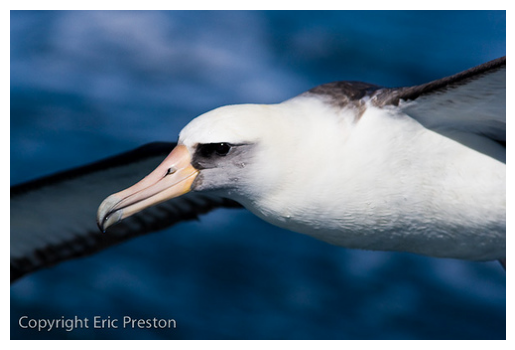

In [15]:
img_id = 80
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])

class_id = labels[labels['image_id'] == img_id]['class_id'].iloc[0]
class_name = " ".join(classes[classes['class_id'] == class_id]['class_name'].iloc[0][4:].split('_'))
print(f'Class: {class_name}')

visible_parts = []
for part in part_locs[part_locs['img_id'] == img_id].itertuples():
    if (part.visible):
        visible_parts.append(parts[parts['part_id'] == part.part_id]['part_name'].iloc[0])
print(f'Visible parts: {visible_parts}')

image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

## Image captioning with no prompt

In [9]:
def generate_blip_caption(image):
    inputs = blip_processor(image, return_tensors="pt").to(DEVICE)
    output = blip_model.generate(**inputs)
    return blip_processor.decode(output[0], skip_special_tokens=True)

Unprompted
BLIP-2 Caption: a white and black bird flying over the ocean



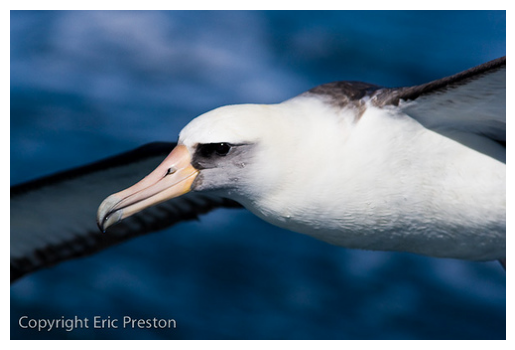

In [16]:
generated_text = generate_blip_caption(image)
print(f'Unprompted')
print(f'BLIP-2 Caption: {generated_text}')
plt.imshow(image)
plt.axis('off')
plt.show()

## Prompted image captioning

In [17]:
def generate_blip_caption_conditioned(image, prompt):
        inputs = blip_processor(image, text=prompt, return_tensors="pt").to(DEVICE)
        output = blip_model.generate(**inputs)
        return blip_processor.decode(output[0], skip_special_tokens=True)

In [12]:
# prompt = 'this is a picture of'
# prompt = 'This type of bird is'
# prompt = 'Describe this bird'
# prompt = 'Bird Description:'
prompt = 'Describe this bird:'

generated_text = generate_blip_caption_conditioned(image, prompt)


Prompt: Describe this bird:
BLIP-2 Caption: Describe this bird:



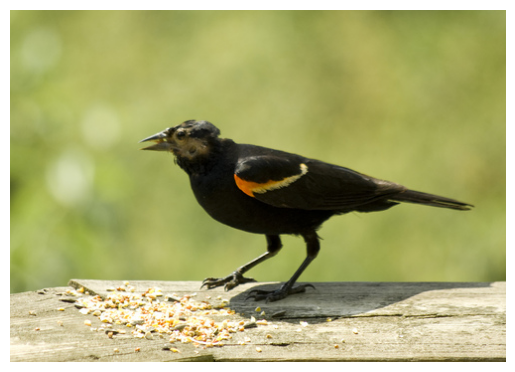

In [13]:
print(f'Prompt: {prompt}')
print(f'BLIP-2 Caption: {generated_text}')
plt.imshow(image)
plt.axis('off')
plt.show()

## Multiple Prompts

In [18]:
generated_text = []
for i in range(len(visible_parts)):
    generated_text.append(generate_blip_caption_conditioned(image, f'Please describe the {visible_parts[i]} of the bird.'))
generated_text.append(generate_blip_caption_conditioned(image, f'Please describe the environment of this bird given it is a {class_name}'))

print(f'BLIP-2 Caption: {" ".join(generated_text)}')
plt.imshow(image)
plt.axis('off')
plt.show()

BLIP-2 Caption: Please describe the back of the bird.
 Please describe the beak of the bird.
 Please describe the breast of the bird.
 Please describe the crown of the bird.
 Please describe the forehead of the bird.
 Please describe the left eye of the bird.
 Please describe the nape of the bird.
 Please describe the right wing of the bird.
 Please describe the throat of the bird.
 Please describe the environment of this bird given it is a Laysan Albatross



NameError: name 'enhanced_image' is not defined

## Visual question answering (VQA)

In [62]:
# prompt = 'Question: which bird is this? Answer:'
prompt = 'Question: which type of bird is this? Answer:'

generated_text = generate_blip_caption_conditioned(image, prompt)
print(f'BLIP-2 Caption: {generated_text}')

BLIP-2 Caption: Question: which type of bird is this? Answer: black-capped chickadee



Prompt: Question: which type of bird is this? Answer:
BLIP-2 Caption: Question: which type of bird is this? Answer: black-capped chickadee



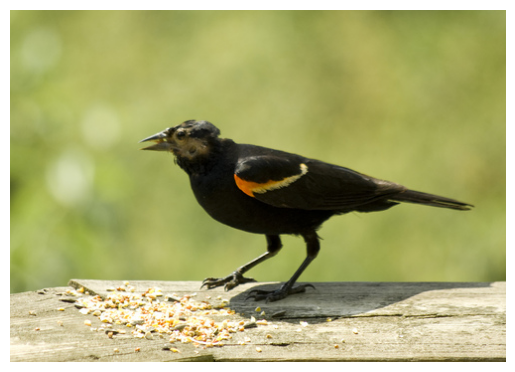

In [63]:
print(f'Prompt: {prompt}')
print(f'BLIP-2 Caption: {generated_text}')
plt.imshow(image)
plt.axis('off')
plt.show()